In [91]:
import tables, glob, os, time, sys
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.colors as colors
from scipy.stats import norm

from stl import mesh
from mpl_toolkits import mplot3d
import scipy.constants as con

In [92]:
def ReadFile(Keys, File): 
    if not os.path.isfile(File):
        print('no')
        return
    else: 
        Data = {}
        try:
            with tables.open_file(File, mode="r") as f: 
                for Key in Keys:    
                    data = f.root._f_get_child(Key)._f_get_child(Key).read()
                    if data is None:
                        print(data)
                    Data[Key] = data
            if Data is None: 
                print(Data)
            return(Data)
        except:
            return 

In [3]:
def GetPhotonFlags(Flags):
    PhotonFlags = {}
    PhotonFlags['NO_HIT'] = (Flags & (0x1 << 0)).astype(bool)   
    PhotonFlags['BULK_ABSORB'] = (Flags & (0x1 << 1)).astype(bool)   
    PhotonFlags['SURFACE_DETECT'] = (Flags & (0x1 << 2)).astype(bool)   
    PhotonFlags['SURFACE_ABSORB'] = (Flags & (0x1 << 3)).astype(bool)   
    PhotonFlags['RAYLEIGH_SCATTER'] = (Flags & (0x1 << 4)).astype(bool)   
    PhotonFlags['REFLECT_DIFFUSE'] = (Flags & (0x1 << 5)).astype(bool)   
    PhotonFlags['REFLECT_SPECULAR'] = (Flags & (0x1 << 6)).astype(bool)    
    PhotonFlags['SURFACE_REEMIT'] = (Flags & (0x1 << 7)).astype(bool)    
    PhotonFlags['SURFACE_TRANSMIT'] = (Flags & (0x1 << 8)).astype(bool)    
    PhotonFlags['BULK_REEMIT'] = (Flags & (0x1 << 9)).astype(bool)   
    PhotonFlags['MATERIAL_REFL'] = (Flags & (0x1 << 10)).astype(bool)  
    PhotonFlags['NAN_ABORT'] = (Flags & (0x1 << 31)).astype(bool)  
    return PhotonFlags

In [4]:
Keys1 = ['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 
                        'Flags', 'FinalPosition', 'NumDetected', 'InitialPosition', 'DetectedPos', 'PhotonWavelength']

#cherenkov source, pos [0,0,-3400], straight down
# File1 = 'h5_files/chroma_nEXO_OD_OD_test_210615_133245_r2794.h5'
# #cherenkov source, pos [0,0,-3400], at corner [0,-1,-1]
# File1 = 'h5_files/chroma_nEXO_OD_OD_test_210615_133535_r3926.h5'
# #cherenkov source, pos [0,0,-3400], at corner [0,-1,-1], more photons and path length 4000 mm
# File1 = 'h5_files/chroma_nEXO_OD_OD_test_210615_145704_r5508.h5'


# #to center with WT surface set to detection: 1.0 
# File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_210621_133834_r5107.h5"
# #to corner with WT surface set to detection: 1.0 s
# File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_210621_134205_r3434.h5"


File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_210624_155631_r4603.h5"

#testing shift of muon input points
File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_210628_142719_r7732.h5"

Data1 = ReadFile(Keys1, File1)

In [5]:
print(Data1.keys())

for var in Data1.keys():
    print(var, "- number of entries:", len(Data1[var]))
    print("     ", Data1[var], '\n')

dict_keys(['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 'Flags', 'FinalPosition', 'NumDetected', 'InitialPosition', 'DetectedPos', 'PhotonWavelength'])
Origin - number of entries: 3
      [[-4.03458118e+00 -2.61812520e+00  5.97019580e+03]
 [ 2.99596542e+03  2.99738187e+03  3.32019580e+03]
 [-3.50403458e+03 -2.61812520e+00 -6.79804199e+02]] 

LastHitTriangle - number of entries: 250000
      [ 16197     -1 119156 ...     -1     -1 117592] 

IncidentAngles - number of entries: 98964
      [41.99780526 41.99780526 41.99780526 ... 38.88845385 19.77173962
 32.24335939] 

DetectorHit - number of entries: 98964
      [[-1340.5671   -208.30638  -681.9539 ]
 [-1340.5671   -208.30638  -681.9539 ]
 [-1340.5671   -208.30638  -681.9539 ]
 ...
 [-1340.5671   -208.30638  -681.9539 ]
 [-1340.5671   -208.30638  -681.9539 ]
 [-1340.5671   -208.30638  -681.9539 ]] 

Flags - number of entries: 250000
      [ 8  2  4 ...  2  2 68] 

FinalPosition - number of entries: 250000
      [[ 1.0448

386.62888


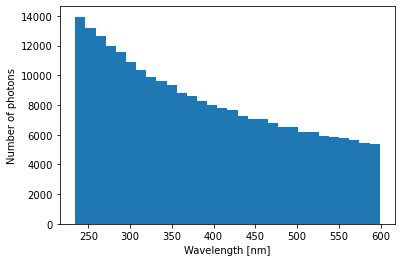

In [8]:
wavelengths = Data1['PhotonWavelength'] 

print(np.average(wavelengths))
plt.hist(wavelengths, bins=30)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Number of photons")
plt.show() 

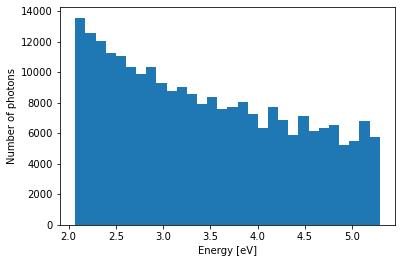

In [23]:
#getting photon energy from wavelength
#E = hc/lambda
c = con.c
h = con.h

#assumes wavelen is in nm
def getEnergyFromWavelen(wavelen):
    E_J = h*c / (wavelen*1e-9)
    return E_J/eVtoJ

eVtoJ = con.physical_constants['electron volt-joule relationship'][0]

E = getEnergyFromWavelen(wavelengths)
plt.hist(E, bins=30)
plt.xlabel("Energy [eV]")
plt.ylabel("Number of photons")
plt.show() 

In [7]:
def plotLightMap(top, side, bottom, title="Light Map", logscale=False):

    fig, axes = plt.subplots(3, 1, figsize=(6,14))

    Colmap=plt.get_cmap('viridis')
    binsize = (50, 50)
    
    fig.suptitle(title)
    #### top of watertank #####
    
#     if logscale:  
#         hist1 = axes[0].hist2d(top[1], top[0], bins=binsize, cmap=Colmap, norm=colors.LogNorm())
#         axes[0].set_facecolor('#440154FF')
        
#     else:
#         hist1 = axes[0].hist2d(top[1], top[0], bins=binsize, cmap=Colmap)

    empty = np.array([[10000], [10000]])
#     hist1 = axes[0].hist2d(empty[1], empty[0], bins=binsize, cmap=Colmap)
    hist1 = axes[0].hist2d([10000], [10000], bins=binsize, cmap=Colmap)
    
    

    axes[0].set_ylabel("X [mm]")
    axes[0].set_xlabel("Y [mm]")
    # axes[0].tick_params(labelbottom=False,labeltop=True)
    axes[0].xaxis.set_ticks_position('top') 
    axes[0].xaxis.set_label_position('top')
    axes[0].set_title('Top', x =1.1, y=0.5,)

    #### wall of watertank #####
    #Azimuthal position [rad]

    if logscale:  
        hist2 = axes[1].hist2d(side[0], side[1], bins=binsize, cmap=Colmap, norm=colors.LogNorm())
        axes[1].set_facecolor('#440154FF')
        
    else:
        hist2 = axes[1].hist2d(side[0], side[1], bins=binsize, cmap=Colmap)
        
    axes[1].set_xlabel("Azimuthal position [rad]")
    axes[1].set_ylabel("Z [mm]")
    axes[1].set_title('Wall', x =1.1, y=0.5,)
    axes[1].set_xticks(np.arange(-np.pi, np.pi+0.1, np.pi/4))
    labels = [r'-$\pi$', r'$-3\pi/4$', r'$-\pi/2$', r'-$\pi/4$', '$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$',]
    axes[1].set_xticklabels(labels)


    #### bottom of watertank #####
#     hist3 = axes[2].hist2d(bottom[0], bottom[1], bins=binsize, cmap=Colmap)
    if logscale:  
        hist3 = axes[2].hist2d(bottom[1], bottom[0], bins=binsize, cmap=Colmap, norm=colors.LogNorm())
        axes[2].set_facecolor('#440154FF')
        
    else:
        hist3 = axes[2].hist2d(bottom[1], bottom[0], bins=binsize, cmap=Colmap)
    axes[2].set_ylabel("X [mm]")
    axes[2].set_xlabel("Y [mm]")
    axes[2].set_title('Bottom', x =1.1, y=0.5,)

    # Find the min and max of all colors for use in setting the color scale.
    images = [hist1[-1], hist2[-1], hist3[-1]]
    vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    if logscale:
        if vmin <= 0 : #if log scale really we need to replace all the 0s with a very small value
            # as we're just counting counts, it just needs to be less than 1
            vmin = 0.1
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
        
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax) 
    for im in images:
        im.set_norm(norm)

    # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.2)

    cbar = fig.colorbar(images[0], ax=axes, shrink=0.95, pad=.14)
    # cbar.set_ticks(np.arange(0, 1.1, 0.5))
    # cbar.set_ticklabels(['low', 'medium', 'high'])
    plt.show()

## Plotting final positions - from just a guess if it's a hit or not

In [13]:
finalPos = Data1['FinalPosition']

# topHeight = 5000
# bottomHeight = -5000
# radius = 6000

topHeight = 4000
bottomHeight = -4000
radius = 5000

#get hits on surfaces
top = []
bottom = []
side = []
all_sides = []
skipped = 0

flagTag = GetPhotonFlags(Data1['Flags'])
# print(flagTag)

saveMaxZ = 0
saveMinZ = 0


for i, pos in enumerate(finalPos):
    if flagTag['BULK_ABSORB'][i]: #don't save any photons that are absorbed in the water
#         print("skip")
        skipped +=1
    else:
        x,y,z = pos
        R = np.sqrt(x*x + y*y)
#         Az = np.arctan(y/x)
        Az = np.arctan2(y, x) #this one should really be used
    
        if saveMaxZ < z:
            saveMaxZ = z
        if saveMinZ > z:
            saveMinZ = z

    #         print([x,y,z], [R, Az, z])

            #save photons that stopped only near the edge of the WT - to be improved later
            if z >= topHeight:
                top.append([x,y])
                all_sides.append([x,y,z])
            elif z <= bottomHeight:
                bottom.append([x,y])
                all_sides.append([x,y,z])
            elif R > radius:
                side.append([Az, z])
                all_sides.append([x,y,z])
            
top = np.array(top).T
bottom = np.array(bottom).T
side = np.array(side).T
all_sides = np.array(all_sides).T

In [14]:
print(saveMaxZ, saveMinZ, skipped)

print(len(top), len(bottom[0]), len(side), len(all_sides[0]))

6169.5894 -7304.4062 121446
0 4 0 4


IndexError: index 0 is out of bounds for axis 0 with size 0

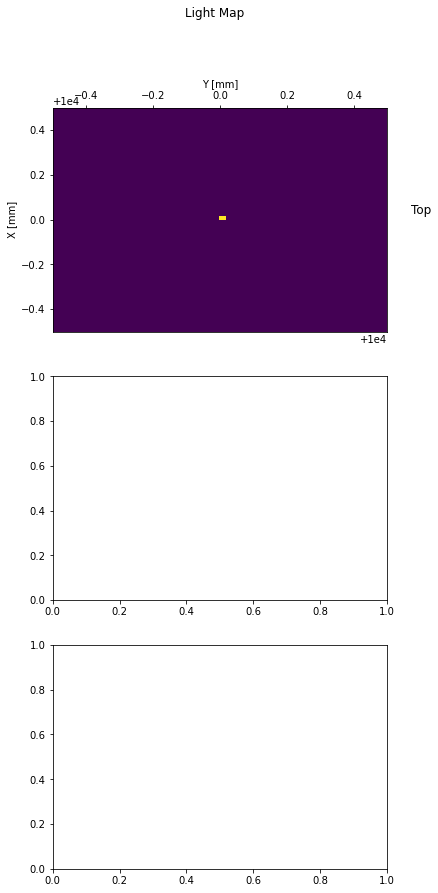

In [15]:
plotLightMap(top, side, bottom, logscale=True)#, title="Light Map")

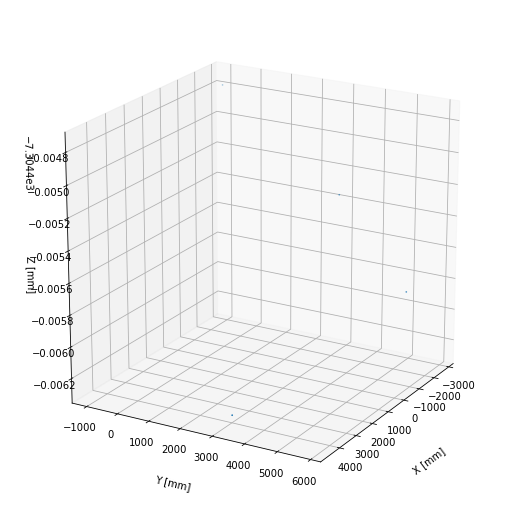

4


In [16]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

p = axes.scatter3D(all_sides[0], all_sides[1], all_sides[2], s=.5)

# axes.set_xlim3d(-6000, 6000)
# axes.set_ylim3d(-6000, 6000)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(20, 30)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()
print(len(all_sides[0]))

## Plotting final positions - from hit flags

In [17]:
detectedPos = Data1['DetectedPos']
# finalPos[:,0]

#approximate values to only plot photons with a dimension larger than these for each of the three graphss
topHeight = 5000
bottomHeight = -5000
radius = 6000

#get hits on surfaces
top_hits = []
bottom_hits = []
side_hits = []
all_sides_hits = []
skipped_hits = 0

PhotonFlags = [GetPhotonFlags(x) for x in Data1['Flags']]

print(PhotonFlags[0])
d = 0

for i, flagtag in enumerate(Data1['Flags']):
#     print(GetPhotonFlags(flagtag))
    if GetPhotonFlags(flagtag)['SURFACE_DETECT']: #only save those that are detected
        x,y,z = detectedPos[d]
        R = np.sqrt(x*x + y*y)
        Az = np.arctan2(y, x)
        
#         print([x,y,z], [R, Az, z])
        
        #save photons that stopped only near the edge of the WT - to be improved later
        if z >= topHeight:
            top_hits.append([x,y])
            all_sides_hits.append([x,y,z])
        elif z <= bottomHeight:
            bottom_hits.append([x,y])
            all_sides_hits.append([x,y,z])
        elif R > radius:
            side_hits.append([Az, z])
            all_sides_hits.append([x,y,z])
        
        d +=1
            
    else:
        skipped +=1
            
top_hits = np.array(top_hits).T
bottom_hits = np.array(bottom_hits).T
side_hits = np.array(side_hits).T
all_sides_hits = np.array(all_sides_hits).T

{'NO_HIT': False, 'BULK_ABSORB': False, 'SURFACE_DETECT': False, 'SURFACE_ABSORB': True, 'RAYLEIGH_SCATTER': False, 'REFLECT_DIFFUSE': False, 'REFLECT_SPECULAR': False, 'SURFACE_REEMIT': False, 'SURFACE_TRANSMIT': False, 'BULK_REEMIT': False, 'MATERIAL_REFL': False, 'NAN_ABORT': False}


In [18]:
# print(len(all_sides_hits[0]))

print("Total of %i photons detected." % len(all_sides_hits[0]))

Total of 98964 photons detected.


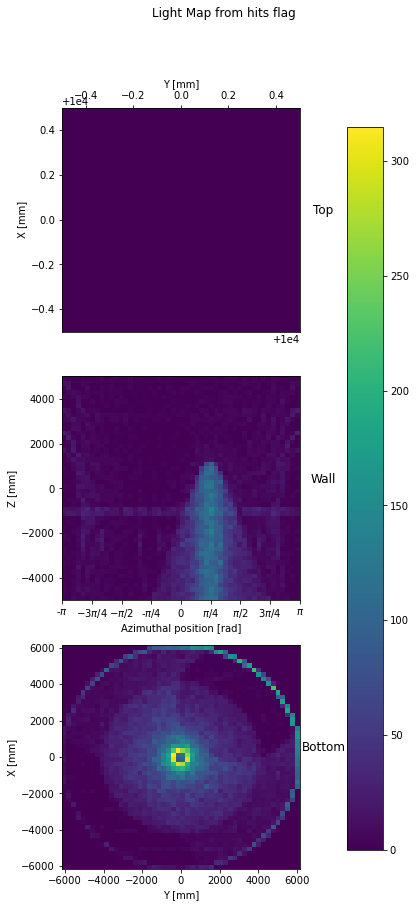

In [19]:
plotLightMap(top_hits, side_hits, bottom_hits, title="Light Map from hits flag")

## Looking at photon paths

In [20]:
I_pos = Data1['InitialPosition'].T
f_pos = Data1['FinalPosition'].T  

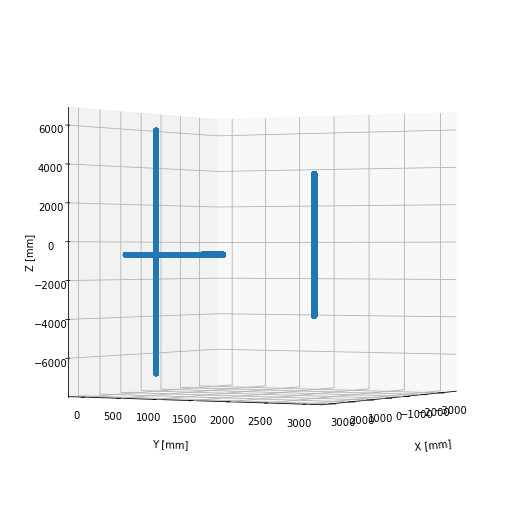

In [25]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

axes.scatter3D(I_pos[0], I_pos[1], I_pos[2], 'blue')
# axes.scatter3D(f_pos[0], f_pos[1], f_pos[2], 'red', alpha=0.1)


# for i in range(len(paths)):
#     direction = np.arange(len(paths[i][0]))#, len(paths[i][0]))

#     axes.plot3D(paths[i][0], paths[i][1], paths[i][2], 'blue', alpha=0.4)
#     p = axes.scatter3D(paths[i][0], paths[i][1], paths[i][2], c=direction, cmap='viridis') #, vmin=0, vmax=ELs_max)
    
#     print(paths[i][0][1], paths[i][1][1], paths[i][2][1])    

# axes.set_xlim3d(-100, 100)
# axes.set_ylim3d(-100, 100)
# axes.set_zlim3d(-3600, -3200)

# axes.set_xlim3d(-6000, 6000)
# axes.set_ylim3d(-6000, 6000)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

# axes.legend()

# fig.colorbar(p, label="Step Number", shrink=0.8)

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 30)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()

# PMT_MetalConnection PMT_Glassware

In [ ]:
# for f in Data1['Flags']:
    
flagTag = GetPhotonFlags(Data1['Flags'])

bars = np.zeros(len(flagTag.keys()))
for i, var in enumerate(flagTag.keys()):
    bars[i] = flagTag[var].sum()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(flagTag.keys(),bars)
plt.xticks(rotation=90)
plt.show()

## Looking at PMTs with Channel data

In [27]:
Keys2 = ['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 'Flags', 'FinalPosition', 'NumDetected', 
         'InitialPosition', 'DetectedPos', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels']

#to center with 12 detecting PMTs
File2 = "h5_files/chroma_nEXO_OD_Rem_test_210622_112356_r4064.h5"

Data2 = ReadFile(Keys2, File1)

In [37]:
print(Data2.keys())

dict_keys(['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 'Flags', 'FinalPosition', 'NumDetected', 'InitialPosition', 'DetectedPos', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels'])


In [33]:
Data2['ChannelIDs']
Data2['NumHitChannels']


PMTHit_pos = Data2['DetectorHit'].T
print(PMTHit_pos)

[[ 3.9252063e+03 -4.0047937e+03  3.9252063e+03  3.9252063e+03
   3.9252063e+03  3.9252063e+03  3.9252063e+03  3.9252063e+03
   3.9252063e+03  3.9252063e+03 -4.0047937e+03  3.9252063e+03
   3.9252063e+03 -4.0047937e+03  3.9252063e+03 -4.0047937e+03]
 [-3.0663898e+00 -3.0663898e+00 -3.0663898e+00 -3.0663898e+00
  -3.0663898e+00 -3.0663898e+00 -3.0663898e+00 -3.0663898e+00
  -3.0663898e+00 -3.0663898e+00 -3.0663898e+00 -3.0663898e+00
  -3.0663898e+00 -3.0663898e+00 -3.0663898e+00 -3.0663898e+00]
 [-7.4666396e+03 -7.4666396e+03 -7.4666396e+03 -7.4666396e+03
  -7.4666396e+03 -7.4666396e+03 -7.4666396e+03 -7.4666396e+03
  -7.4666396e+03 -7.4666396e+03 -7.4666396e+03 -7.4666396e+03
  -7.4666396e+03 -7.4666396e+03 -7.4666396e+03 -7.4666396e+03]]


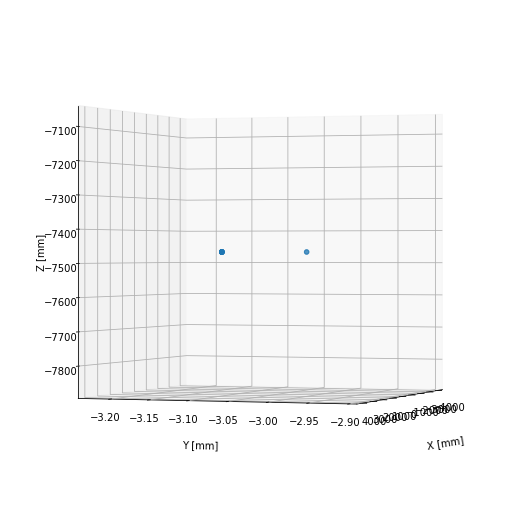

In [36]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

axes.scatter3D(PMTHit_pos[0], PMTHit_pos[1], PMTHit_pos[2], 'blue')
# axes.scatter3D(f_pos[0], f_pos[1], f_pos[2], 'red', alpha=0.1)


# for i in range(len(paths)):
#     direction = np.arange(len(paths[i][0]))#, len(paths[i][0]))

#     axes.plot3D(paths[i][0], paths[i][1], paths[i][2], 'blue', alpha=0.4)
#     p = axes.scatter3D(paths[i][0], paths[i][1], paths[i][2], c=direction, cmap='viridis') #, vmin=0, vmax=ELs_max)
    
# axes.set_xlim3d(-6000, 6000)
# axes.set_ylim3d(-6000, 6000)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

# axes.legend()

# fig.colorbar(p, label="Step Number", shrink=0.8)

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 20)

# 0, 90 - XZ plane; 90, 90 - top views

plt.show()